In [46]:
import pandas as pd
df = pd.read_csv('Processed_Machine_Data.csv')

In [47]:
df_cleaned = pd.get_dummies(df, columns=['Type'])
print(df.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Replace  \
0                    1551         42.8                0        0   
1                    1408         46.3                3        0   
2                    1498         49.4                5        0   
3                    1433         39.5                7        0   
4                    1408         40.0                9        0   

   Machine failure  TWF  HDF  PWF  OSF  RNF  
0                0    0    0    0    0    0  
1                0    0    0    0    0    0  
2                0  

In [48]:
import numpy as np

df_cleaned['Temperature difference'] = df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]']
df_cleaned['Power'] = df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] * (2 * np.pi / 60)
df_cleaned['Torque per RPM'] = df_cleaned['Torque [Nm]'] / df_cleaned['Rotational speed [rpm]']
df_cleaned['Wear per RPM'] = df_cleaned['Tool wear [min]'] / df_cleaned['Rotational speed [rpm]']
df_cleaned['Temperature ratio'] = df_cleaned['Air temperature [K]'] / df_cleaned['Process temperature [K]']
df_cleaned['Tool_wear_diff'] = df_cleaned['Tool wear [min]'].diff().fillna(0)
df_cleaned['Tool_wear_roll_mean'] = df_cleaned['Tool wear [min]'].rolling(window=3, min_periods=1).mean()
df_cleaned['Tool_wear_roll_std'] = df_cleaned['Tool wear [min]'].rolling(window=3, min_periods=1).std().fillna(0)
df_cleaned['TWF_x_wear'] = df_cleaned['TWF'] * df_cleaned['Tool wear [min]']
df_cleaned['Time index'] = np.arange(len(df_cleaned))
df_cleaned['lv'] = pd.cut(
    df['Tool wear [min]'],
    bins=[0, 100, 200, 260],
    labels=['低', '中', '高'],
    right=True,
    include_lowest=True
)

from sklearn.preprocessing import OrdinalEncoder
df_cleaned['lv_code'] = OrdinalEncoder(categories=[['低', '中', '高']]).fit_transform(df_cleaned[['lv']])

# 1. Wear Rate Features
df_cleaned['Wear_rate_per_hour'] = df_cleaned['Tool wear [min]'] / 60  # Convert to hours
df_cleaned['Wear_velocity'] = df_cleaned['Tool wear [min]'] / (df_cleaned['UDI'] + 1)  # Wear per data point
    
# 2. Cumulative Wear Features
df_cleaned['Cumulative_wear'] = df_cleaned['Tool wear [min]'].cumsum()
df_cleaned['Wear_acceleration'] = df_cleaned['Tool wear [min]'].diff().fillna(0)  # Change in wear
    
# 3. Wear Intensity Features
df_cleaned['Wear_per_torque'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Torque [Nm]'] + 0.1)
df_cleaned['Wear_torque_interaction'] = df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]']
df_cleaned['Wear_power_ratio'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Power'] + 0.1)
    
    # === ROLLING WINDOW FEATURES ===
    
    # 4. Rolling Statistics (different windows)
windows = [3, 5, 10, 20]
for window in windows:
    df_cleaned[f'Wear_roll_mean_{window}'] = df_cleaned['Tool wear [min]'].rolling(window, min_periods=1).mean()
    df_cleaned[f'Wear_roll_std_{window}'] = df_cleaned['Tool wear [min]'].rolling(window, min_periods=1).std().fillna(0)
    df_cleaned[f'Wear_roll_max_{window}'] = df_cleaned['Tool wear [min]'].rolling(window, min_periods=1).max()
    df_cleaned[f'Wear_roll_min_{window}'] = df_cleaned['Tool wear [min]'].rolling(window, min_periods=1).min()
    df_cleaned[f'Wear_roll_range_{window}'] = df_cleaned[f'Wear_roll_max_{window}'] - df_cleaned[f'Wear_roll_min_{window}']
    
# 5. Rolling Trends
for window in [5, 10]:
    df_cleaned[f'Wear_trend_{window}'] = df_cleaned['Tool wear [min]'].rolling(window, min_periods=2).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0, raw=True
    )
    
# === EXPONENTIAL MOVING AVERAGES ===
    
    # 6. EMA for different decay rates
alphas = [0.1, 0.3, 0.5]
for alpha in alphas:
    df_cleaned[f'Wear_ema_{int(alpha*10)}'] = df_cleaned['Tool wear [min]'].ewm(alpha=alpha).mean()
    df_cleaned[f'Wear_ema_std_{int(alpha*10)}'] = df_cleaned['Tool wear [min]'].ewm(alpha=alpha).std().fillna(0)
    
    # === WEAR THRESHOLD FEATURES ===
    
    # 7. Threshold-based features
    wear_percentiles = df_cleaned['Tool wear [min]'].quantile([0.25,0.33, 0.5, 0.66, 0.75, 0.9, 0.95])
    
    df_cleaned['Wear_above_p25'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.25]).astype(int)
    df_cleaned['Wear_above_p50'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.5]).astype(int)
    df_cleaned['Wear_above_p75'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.75]).astype(int)
    df_cleaned['Wear_above_p90'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.9]).astype(int)
    df_cleaned['Wear_critical'] = (df_cleaned['Tool wear [min]'] > wear_percentiles[0.95]).astype(int)
    
    # 8. Distance from thresholds
    df_cleaned['Wear_dist_from_p90'] = df_cleaned['Tool wear [min]'] - wear_percentiles[0.9]
    df_cleaned['Wear_dist_from_p95'] = df_cleaned['Tool wear [min]'] - wear_percentiles[0.95]
    
    # === WEAR PATTERN FEATURES ===
    
    # 9. Wear Pattern Detection
    df_cleaned['Wear_is_increasing'] = (df_cleaned['Tool wear [min]'].diff() > 0).astype(int)
    df_cleaned['Wear_consecutive_increases'] = (df_cleaned.groupby((df_cleaned['Wear_is_increasing'] != 
        df_cleaned['Wear_is_increasing'].shift()).cumsum())['Wear_is_increasing'].cumsum() * 
        df_cleaned['Wear_is_increasing'])
    
    # 10. Wear Volatility
    df_cleaned['Wear_volatility_5'] = df_cleaned['Tool wear [min]'].rolling(5, min_periods=1).std().fillna(0)
    df_cleaned['Wear_volatility_10'] = df_cleaned['Tool wear [min]'].rolling(10, min_periods=1).std().fillna(0)
    
    # === INTERACTION WITH OPERATING CONDITIONS ===
    
    # 11. Temperature-Wear Interactions
    df_cleaned['Wear_temp_ratio'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]'] + 1)
    df_cleaned['Wear_x_temp_diff'] = df_cleaned['Tool wear [min]'] * (df_cleaned['Process temperature [K]'] - df_cleaned['Air temperature [K]'])
    df_cleaned['Wear_per_avg_temp'] = df_cleaned['Tool wear [min]'] / ((df_cleaned['Process temperature [K]'] + df_cleaned['Air temperature [K]']) / 2)
    
    # 12. Speed-Wear Interactions
    df_cleaned['Wear_speed_stress'] = df_cleaned['Tool wear [min]'] * df_cleaned['Rotational speed [rpm]'] / 1000
    df_cleaned['Wear_per_speed_squared'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Rotational speed [rpm]']**2 + 1)
    
    # === ADVANCED DERIVED FEATURES ===
    
    # 13. Wear Efficiency Metrics
    df_cleaned['Wear_efficiency'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]'] / 1000 + 1)
    df_cleaned['Wear_per_work'] = df_cleaned['Tool wear [min]'] / (df_cleaned['Power'] * df_cleaned['UDI'] + 1)  # Wear per unit work done
    
    # 14. Normalized Wear Features
    df_cleaned['Wear_normalized_by_max'] = df_cleaned['Tool wear [min]'] / df_cleaned['Tool wear [min]'].max()
    df_cleaned['Wear_z_score'] = (df_cleaned['Tool wear [min]'] - df_cleaned['Tool wear [min]'].mean()) / df_cleaned['Tool wear [min]'].std()
    
    # 15. Wear Regime Classification
    df_cleaned['Wear_regime'] = pd.cut(df_cleaned['Tool wear [min]'], 
                              bins=[0, wear_percentiles[0.33], wear_percentiles[0.66], float('inf')], 
                              labels=['Low', 'Medium', 'High'])
    df_cleaned['Wear_regime_encoded'] = df_cleaned['Wear_regime'].cat.codes
    
# === TIME-BASED WEAR FEATURES ===
    
# 16. Lag Features
for lag in [1, 2, 3, 5]:
    df_cleaned[f'Wear_lag_{lag}'] = df_cleaned['Tool wear [min]'].shift(lag).fillna(0)
    df_cleaned[f'Wear_diff_lag_{lag}'] = df_cleaned['Tool wear [min]'] - df_cleaned[f'Wear_lag_{lag}']
    
# 17. Future-looking features (if predicting failure)
for lead in [1, 2, 3]:
    df_cleaned[f'Wear_lead_{lead}'] = df_cleaned['Tool wear [min]'].shift(-lead).fillna(df_cleaned['Tool wear [min]'].iloc[-1])
    df_cleaned[f'Wear_will_increase_{lead}'] = (df_cleaned[f'Wear_lead_{lead}'] > df_cleaned['Tool wear [min]']).astype(int)
    
# === WEAR ANOMALY FEATURES ===
    
# 18. Outlier Detection
Q1 = df_cleaned['Tool wear [min]'].quantile(0.25)
Q3 = df_cleaned['Tool wear [min]'].quantile(0.75)
IQR = Q3 - Q1
    
df_cleaned['Wear_is_outlier'] = ((df_cleaned['Tool wear [min]'] < (Q1 - 1.5 * IQR)) | 
                            (df_cleaned['Tool wear [min]'] > (Q3 + 1.5 * IQR))).astype(int)
df_cleaned['Wear_outlier_score'] = ((df_cleaned['Tool wear [min]'] - Q1) / IQR).clip(lower=0, upper=1)    

# 19. Sudden Change Detection
df_cleaned['Wear_sudden_jump'] = (df_cleaned['Tool wear [min]'].diff() > df_cleaned['Tool wear [min]'].diff().quantile(0.95)).astype(int)
df_cleaned['Wear_sudden_drop'] = (df_cleaned['Tool wear [min]'].diff() < df_cleaned['Tool wear [min]'].diff().quantile(0.05)).astype(int)
    
# === COMPOSITE WEAR INDICES ===
    
# 20. Wear Composite Scores
df_cleaned['Wear_composite_1'] = (df_cleaned['Tool wear [min]'] * df_cleaned['Torque [Nm]'] * df_cleaned['Rotational speed [rpm]']) / 10000
df_cleaned['Wear_composite_2'] = df_cleaned['Tool wear [min]'] * df_cleaned['Temperature ratio'] * df_cleaned['Torque per RPM']
    
# 21. Wear Risk Score (combining multiple factors)
df_cleaned['Wear_risk_score'] = (
    df_cleaned['Wear_above_p75'] * 0.3 +
    df_cleaned['Wear_trend_5'] * 0.2 +
    df_cleaned['Wear_volatility_5'] * 0.2 +
    df_cleaned['Wear_is_outlier'] * 0.3
)

=== MIXED DATA TYPE CORRELATION ANALYSIS ===
Feature type distribution:
  Numerical: 83 features
  Categorical: 0 features
    []
  Binary: 20 features
  Datetime: 0 features
    []
  Other: 4 features
    ['Product ID', 'lv', 'Wear_regime', 'Wear_regime_encoded']

1. NUMERICAL-NUMERICAL CORRELATIONS


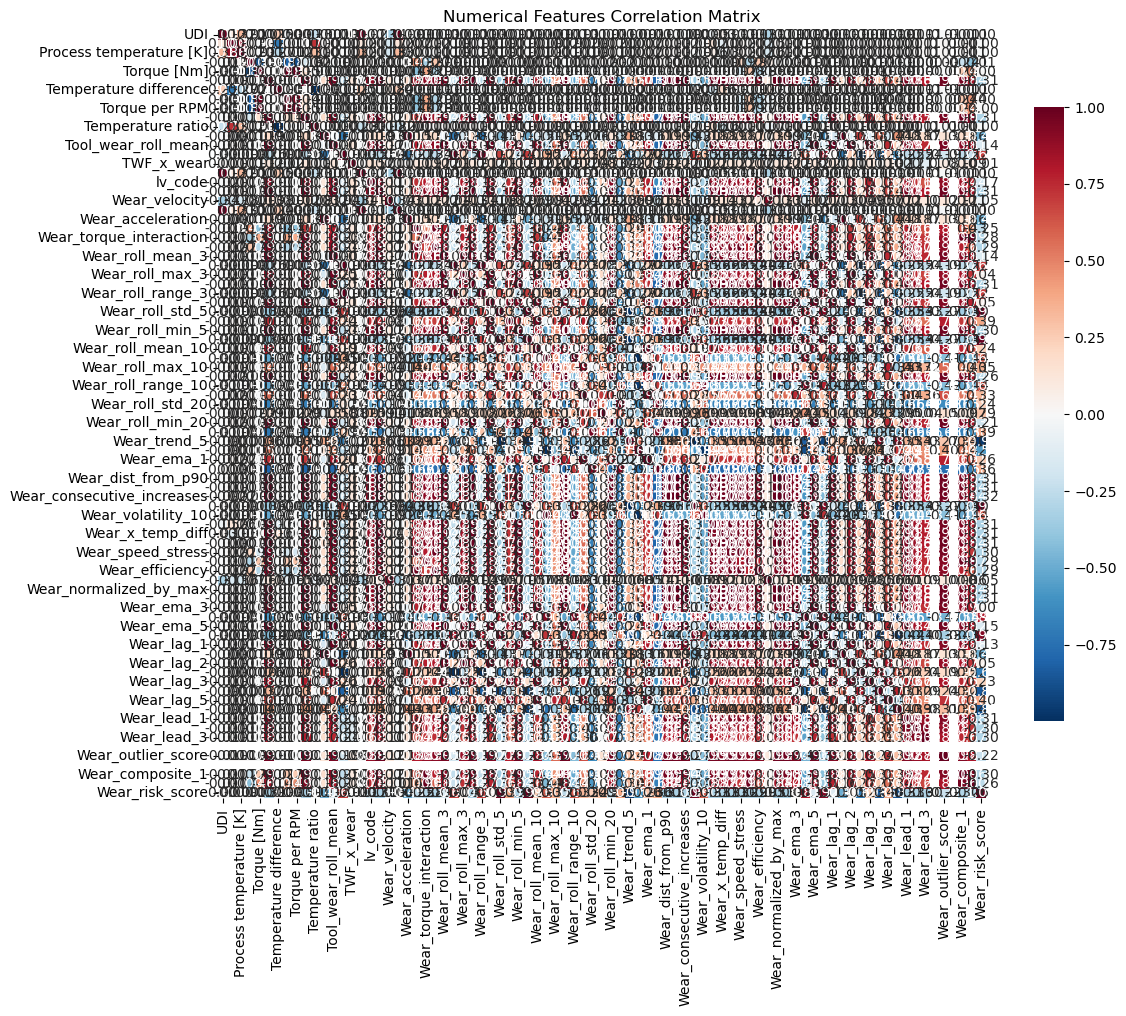

High numerical correlations (|r| >= 0.7):
  Tool wear [min] ↔ Wear_rate_per_hour: 1.000
  Wear_rate_per_hour ↔ Wear_dist_from_p90: 1.000
  Wear_rate_per_hour ↔ Wear_dist_from_p95: 1.000
  Tool wear [min] ↔ Wear_z_score: 1.000
  Wear_dist_from_p90 ↔ Wear_z_score: 1.000
  Wear_dist_from_p95 ↔ Wear_z_score: 1.000
  Tool wear [min] ↔ Wear_normalized_by_max: 1.000
  Wear_dist_from_p90 ↔ Wear_normalized_by_max: 1.000
  Wear_dist_from_p95 ↔ Wear_normalized_by_max: 1.000
  UDI ↔ Time index: 1.000

4. BINARY-NUMERICAL CORRELATIONS (Point-biserial)


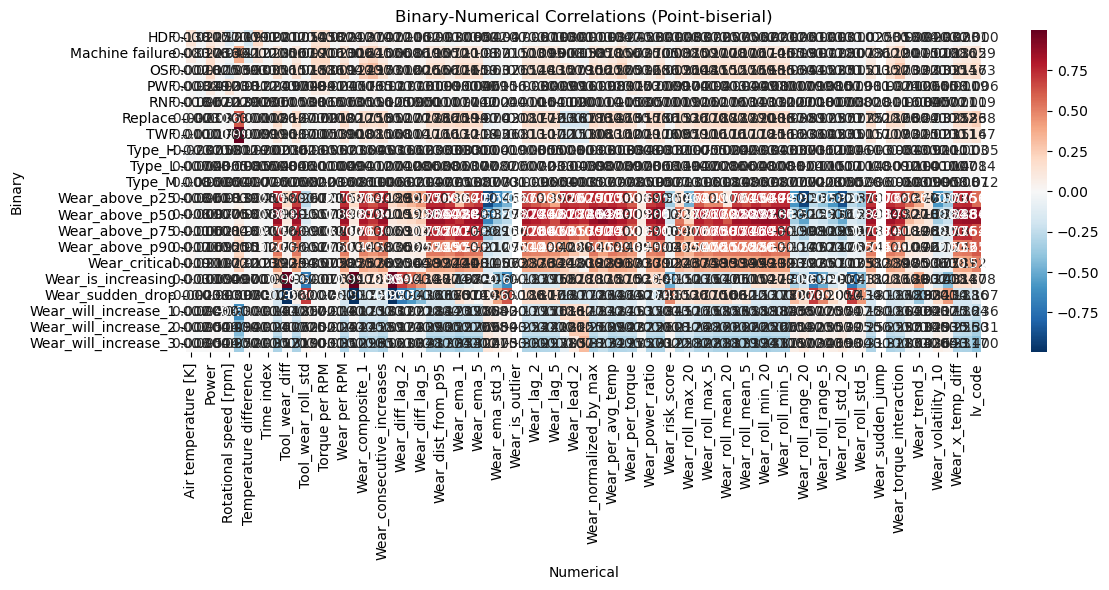


5. TARGET VARIABLE ANALYSIS: 'Wear_roll_mean_5'


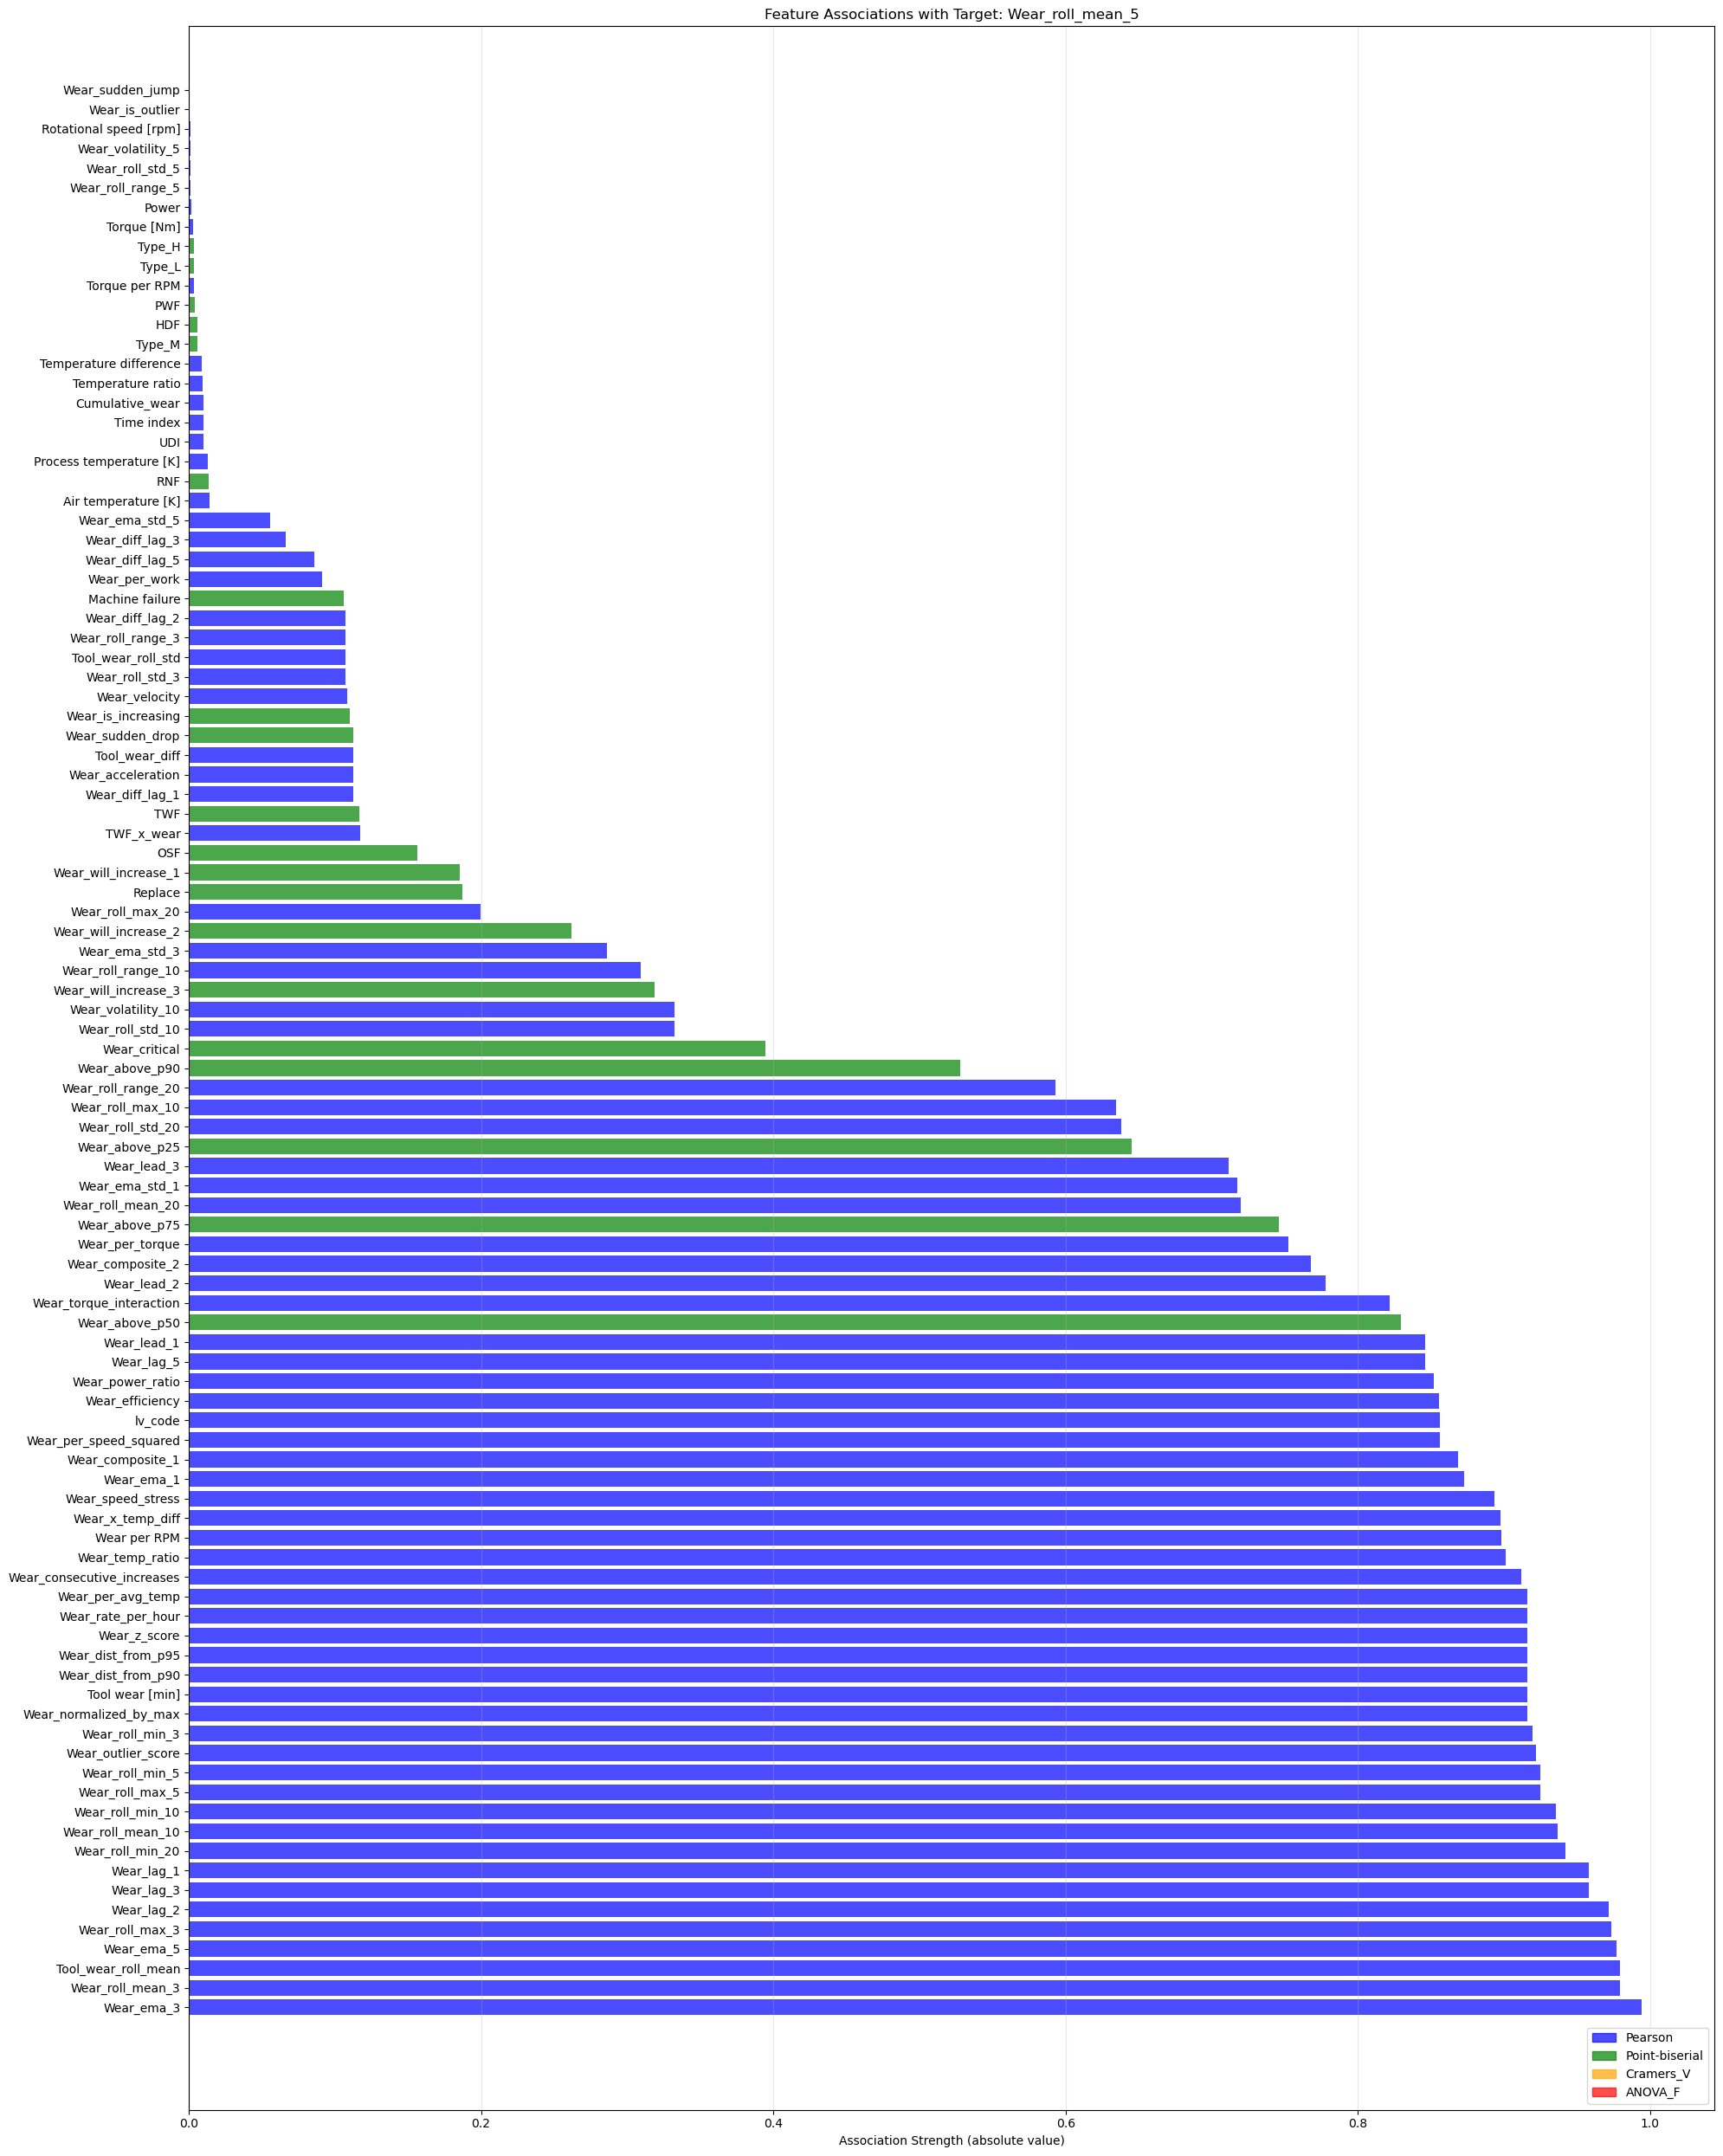


6. COMPREHENSIVE CORRELATION SUMMARY
Summary of strongest associations:

Top 10 strongest associations:
 1. Tool wear [min] ↔ Wear_rate_per_hour: 1.000 (Pearson)
 2. Wear_rate_per_hour ↔ Wear_dist_from_p90: 1.000 (Pearson)
 3. Wear_rate_per_hour ↔ Wear_dist_from_p95: 1.000 (Pearson)
 4. Tool wear [min] ↔ Wear_z_score: 1.000 (Pearson)
 5. Wear_dist_from_p90 ↔ Wear_z_score: 1.000 (Pearson)
 6. Wear_ema_3 ↔ TARGET: 0.994 (Pearson)
 7. Tool_wear_roll_mean ↔ TARGET: 0.979 (Pearson)
 8. Wear_roll_mean_3 ↔ TARGET: 0.979 (Pearson)
 9. Wear_ema_5 ↔ TARGET: 0.977 (Pearson)
10. Wear_roll_max_3 ↔ TARGET: 0.973 (Pearson)


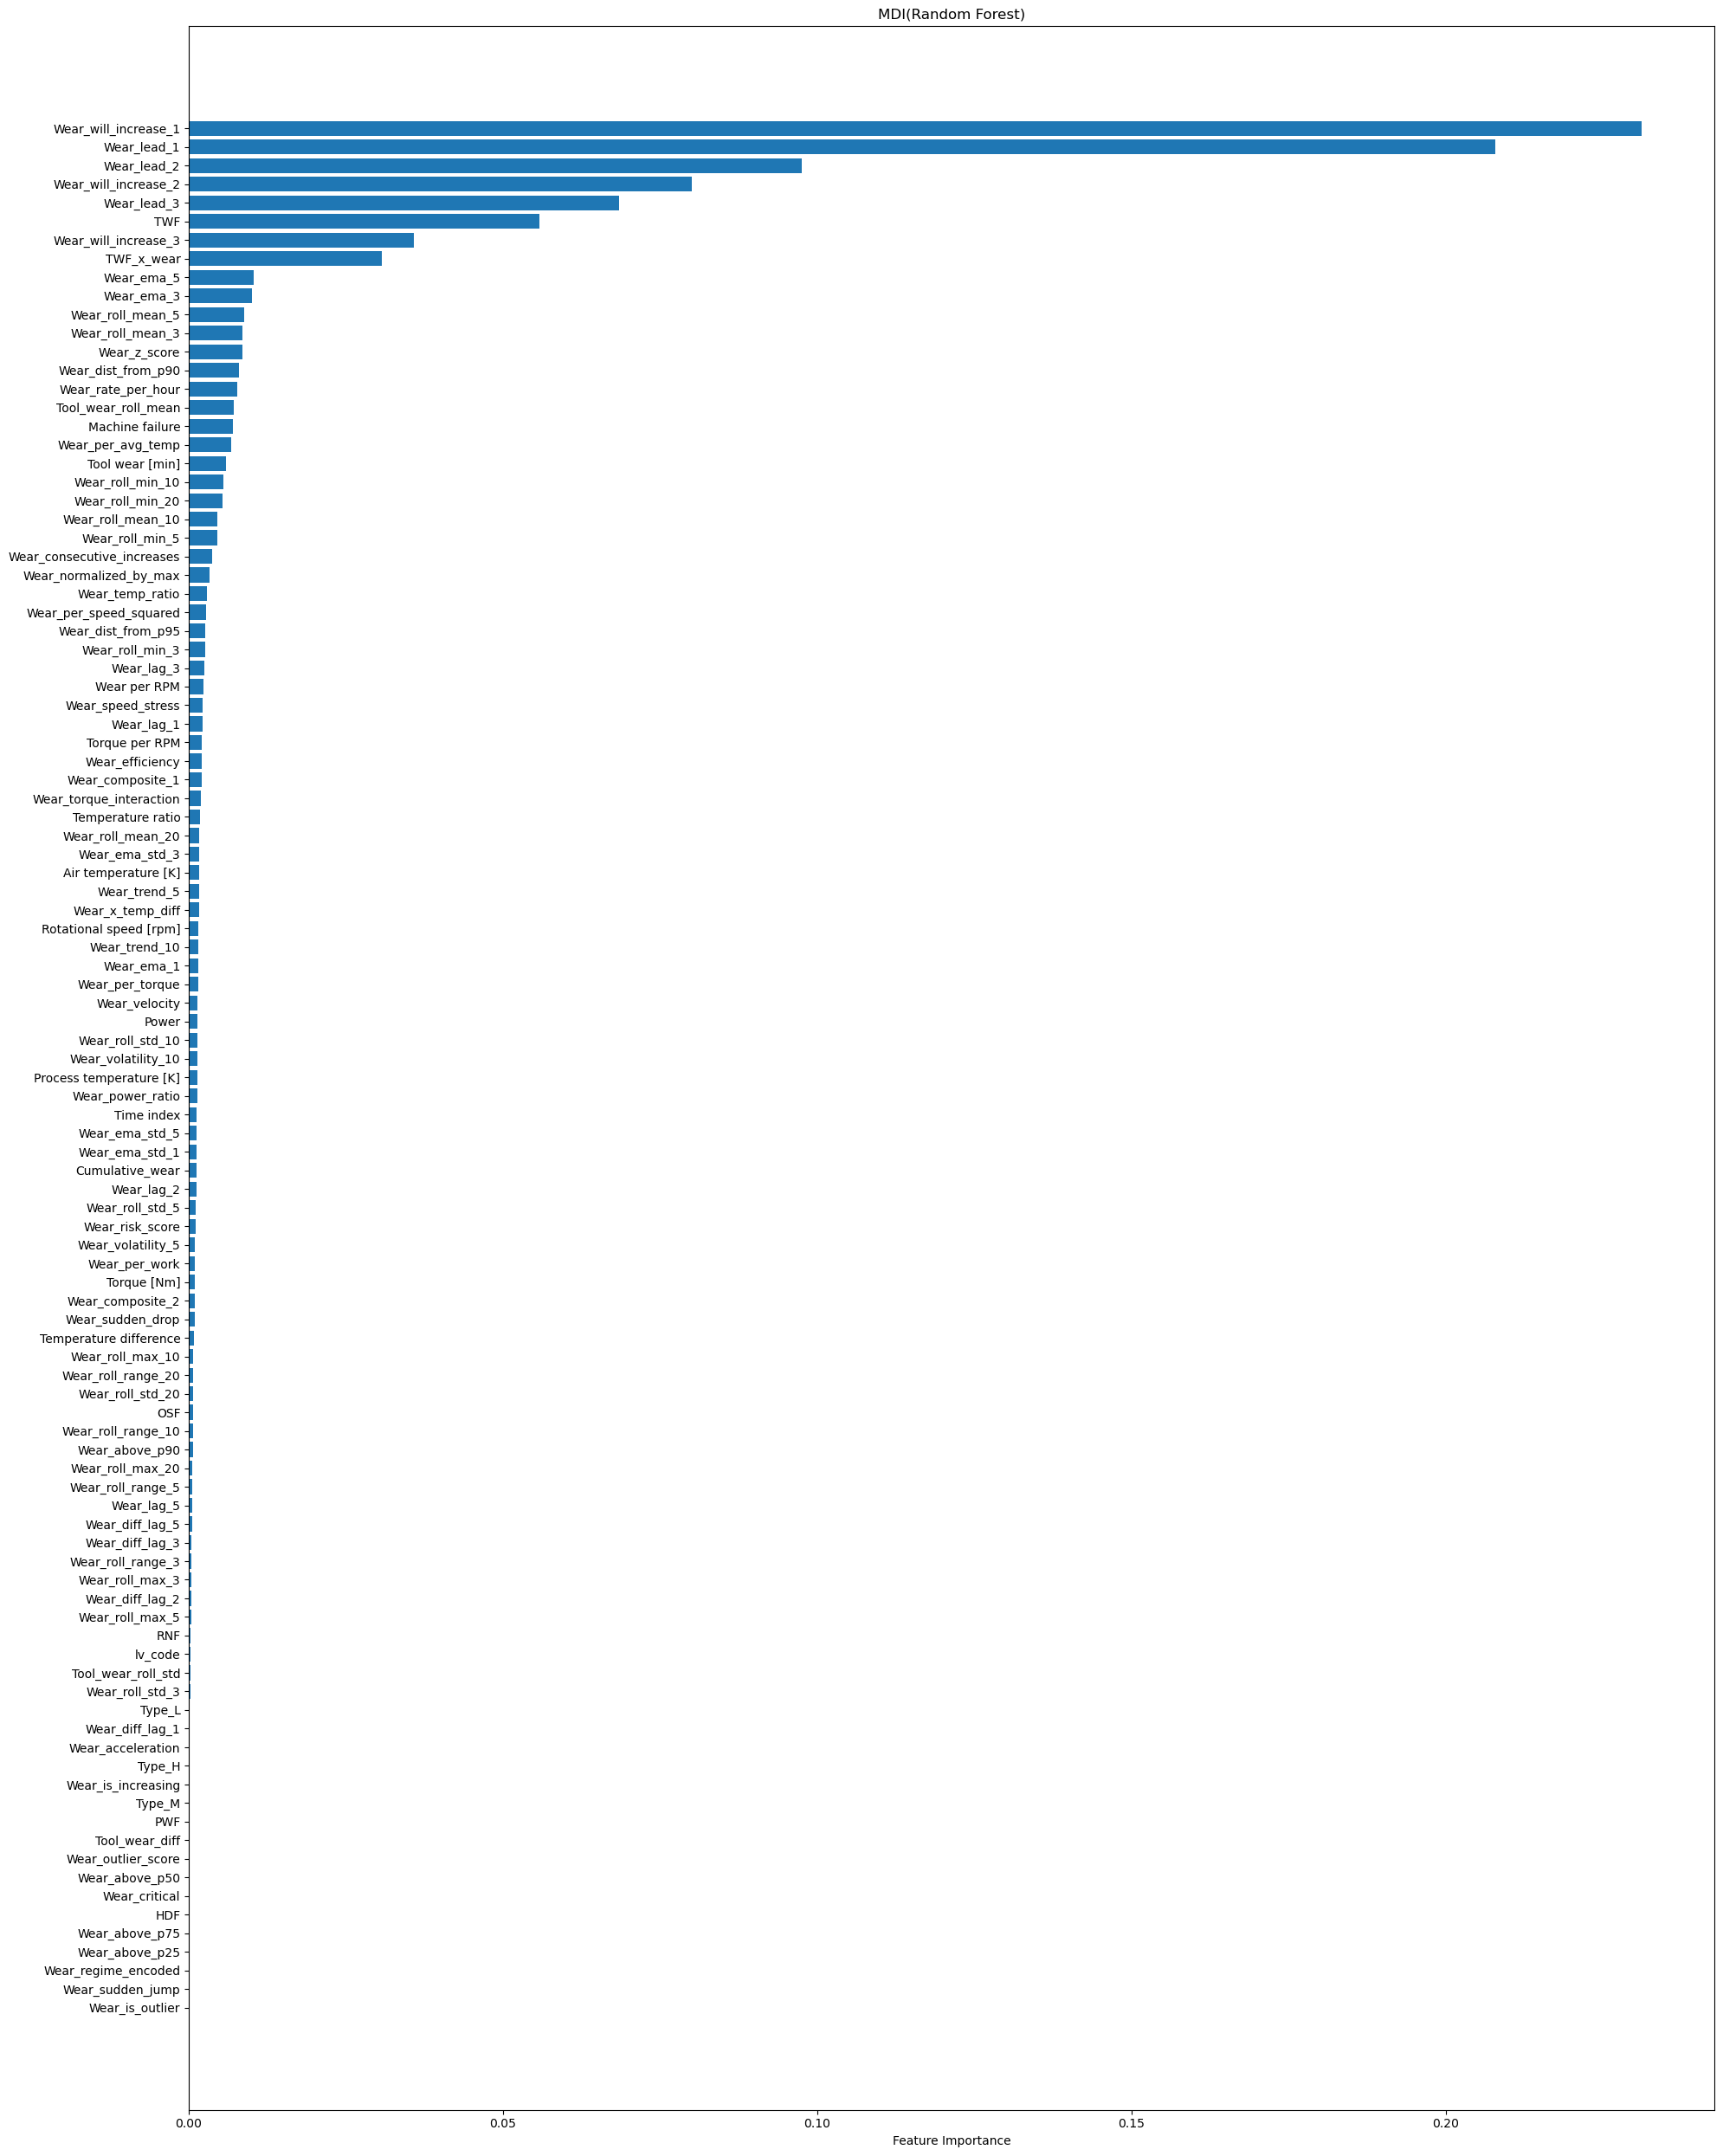

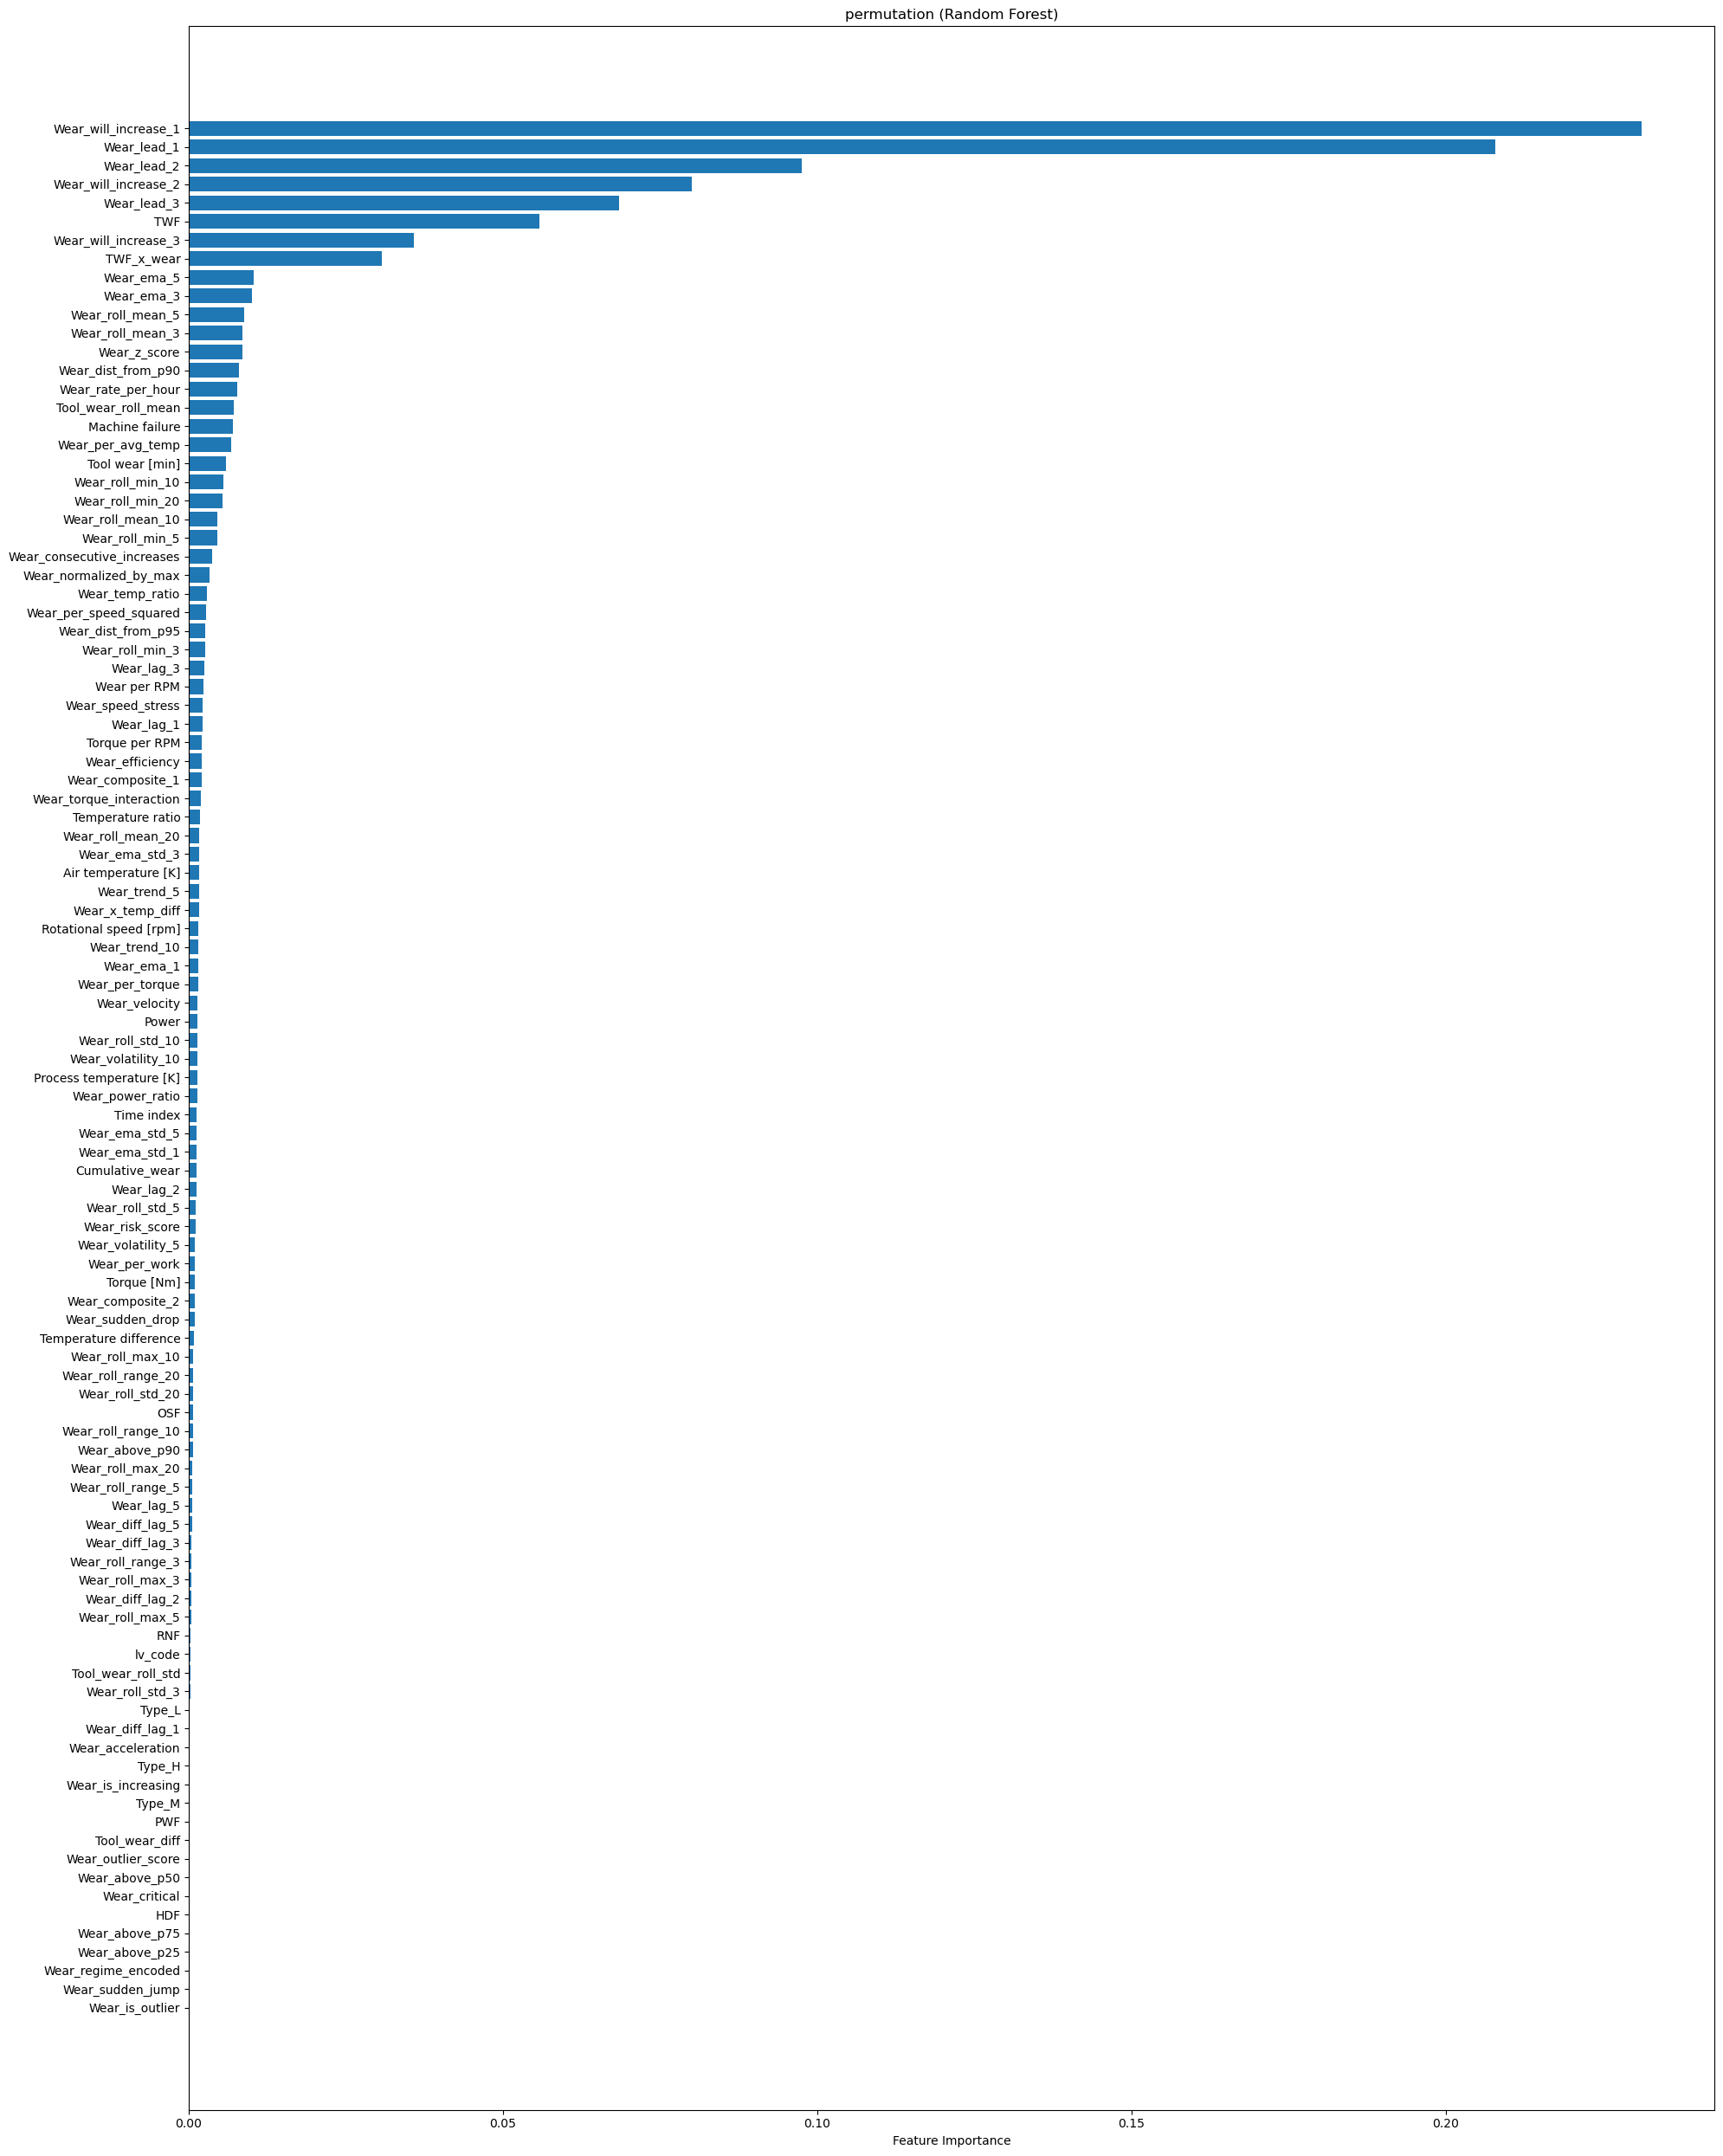

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from threshold_optimzation import analyze_mixed_correlations

X = df_cleaned.drop(columns=['Replace', 'Wear_regime', 'lv', 'UDI', 'Product ID'])
y = df_cleaned['Replace']


corr_matrix = analyze_mixed_correlations(df_cleaned, target_col='Wear_roll_mean_5')



rf = RandomForestClassifier(n_estimators=300, class_weight= {0:1, 1:1.5}, oob_score=True, random_state=0)
rf.fit(X, y)

mdi = rf.feature_importances_ 
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mdi
}).sort_values(by='Importance', ascending=False)

# 繪製視覺化
plt.figure(figsize=(20, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("MDI(Random Forest)")
plt.tight_layout()
plt.show()
         # mean decrease impurity
perm = permutation_importance(rf, X, y,
                              n_repeats=10, random_state=0,
                              scoring="f1").importances_mean
feature_importance_perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20, 25))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("permutation (Random Forest)")
plt.tight_layout()
plt.show()

In [50]:
from sklearn.model_selection import train_test_split

# 選定特徵與標籤
features = [
    'Tool_wear_roll_mean',
    'Wear per RPM',
    'Tool wear [min]',
    'Machine failure',
    'TWF_x_wear',
    'Rotational speed [rpm]',
    'Torque [Nm]', 
    'Power', 
    'Torque per RPM',
    'Temperature ratio',
    'lv_code'

    #'Wear_rate_per_hour',
    #'Wear_power_ratio',
    #'Wear_per_torque',
    #'Wear_torque_interaction',
]

features_t10=[

    'Wear_will_increase_1',    
    'Wear_roll_min_20',

    'Wear_lead_1',
    'Wear_lag_5',

    'TWF_x_wear',
    'Machine failure',

    'Wear_ema_5',
    'Wear_critical',

    'Wear_roll_mean_5',
    'Wear_above_p25',
]

target_col = 'Replace'

X = df_cleaned[features_t10]
y = df_cleaned[target_col]

# 切割資料集（80% 訓練集，20% 測試集），並維持標籤分布
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('訓練集筆數:', X_train.shape[0])
print('測試集筆數:', X_test.shape[0])

訓練集筆數: 8000
測試集筆數: 2000


=== 交叉驗證過程 ===
第1折: 最佳門檻=0.10, F1-score=1.000
第2折: 最佳門檻=0.10, F1-score=1.000
第3折: 最佳門檻=0.10, F1-score=1.000
第4折: 最佳門檻=0.10, F1-score=1.000
第5折: 最佳門檻=0.10, F1-score=1.000
第6折: 最佳門檻=0.10, F1-score=1.000
第7折: 最佳門檻=0.10, F1-score=1.000
第8折: 最佳門檻=0.10, F1-score=1.000
第9折: 最佳門檻=0.10, F1-score=1.000
第10折: 最佳門檻=0.10, F1-score=1.000

最佳門檻平均值為 0.10
所有折中最佳 F1-score (失敗類): 1.000

=== 測試集 ===
最佳門檻為 0.10，此時 F1-score (失敗類) 為 1.000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1976
           1       1.00      1.00      1.00        24

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



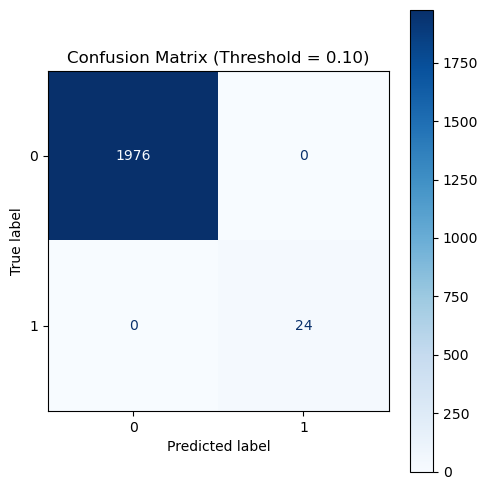

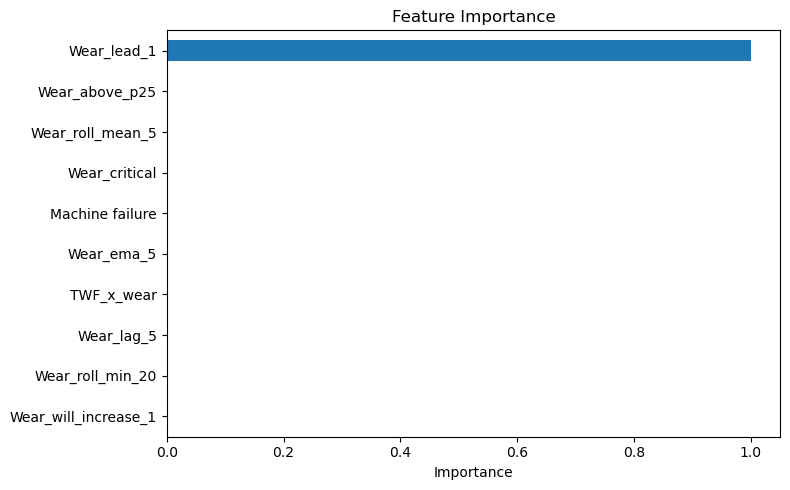

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline


skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe = Pipeline([
    ('smote', SMOTETomek(sampling_strategy=0.20, random_state=42)),
    ('clf', DecisionTreeClassifier(
        random_state=7414,
        class_weight={0:1, 1:1.5},
        max_depth=7,
        max_features=4,
        min_samples_leaf=5,
        min_samples_split=70,
        ccp_alpha=0,
        criterion='entropy',
        splitter='best'
    ))
])

thresholds = np.arange(0.1, 0.91, 0.05)

f1_list = []
best_thresholds = []

print("=== 交叉驗證過程 ===")
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    pipe.fit(X_tr, y_tr)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    best_f1 = 0
    best_thres = 0.5
    for thres in thresholds:
        y_pred = (y_proba >= thres).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thres = thres
    print(f"第{fold}折: 最佳門檻={best_thres:.2f}, F1-score={best_f1:.3f}")
    f1_list.append(best_f1)
    best_thresholds.append(best_thres)

# 找出所有折最佳門檻的平均值
final_best_thres = np.mean(best_thresholds)
print(f"\n最佳門檻平均值為 {final_best_thres:.2f}")
print(f"所有折中最佳 F1-score (失敗類): {np.max(f1_list):.3f}")

# 用最佳門檻評估測試集
pipe.fit(X_train, y_train)
y_proba_test = pipe.predict_proba(X_test)[:, 1]


y_pred_best = (y_proba_test >= final_best_thres).astype(int)

print(f"\n=== 測試集 ===")
print(f"最佳門檻為 {final_best_thres:.2f}，此時 F1-score (失敗類) 為 {f1_score(y_test, y_pred_best, pos_label=1):.3f}\n")
print(classification_report(y_test, y_pred_best, digits=2))



# 混淆矩陣
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap='Blues', values_format='d')  # 'd' 表示整數顯示
plt.title(f"Confusion Matrix (Threshold = {final_best_thres:.2f})")
plt.tight_layout()
plt.show()
import pandas as pd
# ===== 5. 特徵重要性視覺化 =====
clf = pipe.named_steps['clf']
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8, 5), title="Feature Importance")
plt.xlabel('Importance')
plt.tight_layout()
plt.show()